In [78]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

common_seed = 42
np.random.seed(common_seed)
tf.random.set_seed(common_seed)
random.seed(common_seed)


from dataclasses import dataclass
@dataclass
class TrainParameters():
    import os
    import time
    from typing import List
    from dataclasses import field
    
    import tensorflow as tf
    from tensorflow.keras.layers import LSTM
    from tensorflow.python.keras.engine import base_layer
    
    window_size : int = 50
    predict_step : int = 1
    test_split  : float = 0.20
    feature_columns : list = field(default_factory = lambda: ["adjclose", "volume", "open", "high", "low"])
    scale : bool = True
    shuffle : bool = True
    date_now : time = time.strftime("%Y-%m-%d")
    model_layers: int = 3
    model_cell : base_layer = LSTM
    lstm_neurons : int = 256
    dropout : float = 0.40
    
    ### training parameters
    # mean absolute error loss
    # LOSS = "mae"
    # huber loss
    loss : str = "huber_loss"
    optimizer: str = "adam"
    batch_size : int = 64
    epochs : int = 400

    ticker : str = 'MSFT'

    #both must be dynamoic as they are resolved late.
    @property
    def ticker_file(self):
        import os
        return os.path.join("data", f"{self.ticker}_{self.date_now}.csv")
        
    @property
    def model_name(self):
        # model name to save, making it as unique as possible based on parameters
        return f"{self.date_now}_{self.ticker}-{self.loss}-{self.optimizer}-{self.model_cell.__name__}-seq-{self.window_size}-step-{self.predict_step}-layers-{self.model_layers}-units-{self.lstm_neurons}"


def load_data(p : TrainParameters):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        window_size (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        predict_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    
    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split
    from yahoo_fin import stock_info as si
    from collections import deque
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(p.ticker, str):
        # load it from yahoo_fin library
        print('calling yahoo fin...')
        df = si.get_data(p.ticker)
    elif isinstance(p.ticker, pd.DataFrame):
        # already loaded, use it directly
        print('data loaded as a Pandas DataFrame')
        df = p.ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in p.feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    if p.scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in p.feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `predict_step`
    # this makes 'future' the price FROM the future for that set of features.
    # eg. feature date 2/15/20 -- price date is from 2/16/20
    df['future'] = df['adjclose'].shift(-p.predict_step)

    # last `predict_step` columns contains NaN in FUTURE column
    # get them before droping NaNs
    last_sequence = np.array(df[p.feature_columns].tail(p.predict_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=p.window_size)

    for entry, target in zip(df[p.feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == p.window_size:
            #now we can add the future price as we are at the end of the sequence
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `predict_step` sequence
    # for instance, if window_size=50 and predict_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # reshape X to fit the neural network
    print(f'X shape: {X.shape}')
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    print(f'X shape after: {X.shape}')
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=p.test_split, shuffle=p.shuffle)
    # return the result
    return result


def create_model(p : TrainParameters):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout    

    model = Sequential()
    for i in range(p.model_layers):
        if i == 0:
            # first layer
            model.add(p.model_cell(p.lstm_neurons, return_sequences = True, input_shape = (None, p.window_size)))
        elif i == p.model_layers - 1:
            # last layer
            model.add(p.model_cell(p.lstm_neurons, return_sequences= False))
        else:
            # hidden layers
            model.add(p.model_cell(p.lstm_neurons, return_sequences = True))
        # add dropout after each layer
        model.add(Dropout(p.dropout))
        
    #final layer is 1 output given "prediction"
    model.add(Dense(1, activation="linear"))
    model.compile(loss = p.loss, metrics=["mean_absolute_error"], optimizer = p.optimizer)
    return model


def plot_graph2(model, X_actual, y_actual, p : TrainParameters, back_range = 200, figure_size = (15,15)):
    import matplotlib.pyplot as plt
    plt.figure(figsize = figure_size)
    
    y_pred = model.predict(X_actual)
    if p.scale:
        y_actual = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_actual, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))

    else:
        pass
        #y_test = np.squeeze(np.expand_dims(y_test, axis=0))
        #y_pred = np.squeeze(y_pred)
        
    plt.plot(y_actual[-back_range:], c='c') #b
    plt.plot(y_pred[-back_range:], c='k') #r
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    
def plot_graph(model, data, p : TrainParameters, back_range = 200, figure_size = (15,15)):
    import matplotlib.pyplot as plt
    plt.figure(figsize = figure_size)
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    if p.scale:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))

    else:
        pass
        #y_test = np.squeeze(np.expand_dims(y_test, axis=0))
        #y_pred = np.squeeze(y_pred)
        
    plt.plot(y_test[-back_range:], c='c') #b
    plt.plot(y_pred[-back_range:], c='k') #r
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()


def get_accuracy(model, data, p: TrainParameters):
    from sklearn.metrics import accuracy_score
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    if p.scale:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))

    else:
        pass
        #y_test = np.squeeze(np.expand_dims(y_test, axis=0))
        #y_pred = np.squeeze(y_pred)
    
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-p.predict_step], y_pred[p.predict_step:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-p.predict_step], y_test[p.predict_step:]))
    return accuracy_score(y_test, y_pred)


def predict(model, data, p: TrainParameters):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:p.window_size]

    # reshape the last sequence  - flip the x,y
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    if p.scale:
    # get the price (by inverting the scaling)
        # retrieve the column scalers
        column_scaler = data["column_scaler"]
        predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
        return predicted_price

    else:
        predicted_price = prediction[0][0]
        return predicted_price
    


In [95]:
# TODO: work plotting as it's using the X_train/test data which isn't the Last N items.

ticker_or_file = 'MSFT'
# comment this next line to read from internet.
file_from_csv = pd.read_csv('data/MSFT_2020-05-04.csv')
ticker_or_file = file_from_csv

run_parms = TrainParameters(
                ticker = ticker_or_file,
                epochs=1, 
                predict_step=1, # predict 1 day in the future.
                window_size=50,
                scale = False)

data = load_data(run_parms)

if not os.path.isdir("data"):
    os.mkdir("data")
    
#data['df'].to_csv(run_parms.ticker_file)

model = create_model(run_parms)

X shape: (8556, 50, 5)
X shape after: (8556, 5, 50)


In [96]:
history = model.fit(data["X_train"], data["y_train"],
                    batch_size = run_parms.batch_size,
                    epochs = run_parms.epochs,
                    validation_data = (data["X_test"], data["y_test"]),
                    #callbacks=[checkpointer, tensorboard],
                    verbose=1)

Train on 6844 samples, validate on 1712 samples
6844/6844 [==============================] - 7s 957us/sample - loss: 18.1829 - mean_absolute_error: 18.6698 - val_loss: 17.2064 - val_mean_absolute_error: 17.6923


In [97]:
# df is a copy of the data frame - raw data 
# column_scaler are the instances used to scale each column.
# last_sequence are the prediction window
# X_train/test and Y_train/test are the respective splitsd
[k for k in data]

['df', 'last_sequence', 'X_train', 'X_test', 'y_train', 'y_test']

Mean Absolute Error: 18.448524
Future price after 1 days is $ 19.20
Accuracy Score: 0.755698421975453


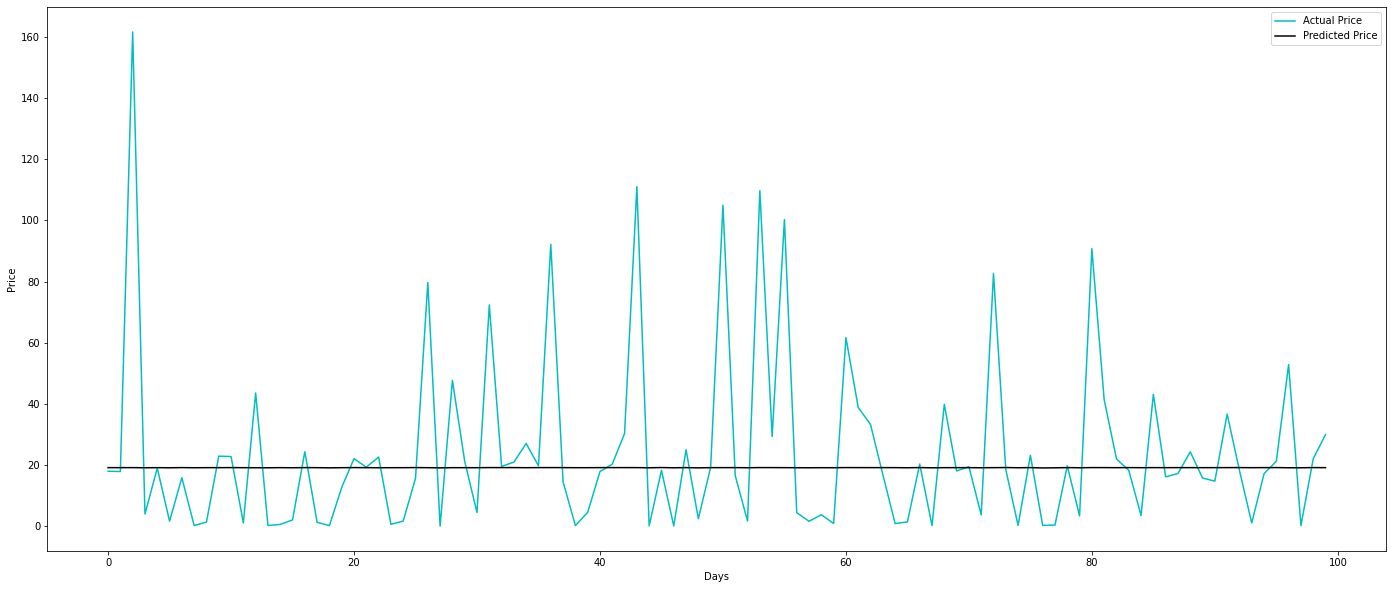

In [98]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)


if run_parms.scale:
# calculate the mean absolute error (inverse scaling)
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
else:
    pass #mean_absolute_error = mae.reshape(1, -1)[0][0]

print("Mean Absolute Error:", mean_absolute_error)

# predict the future price
future_price = predict(model, data, run_parms)
print(f"Future price after {run_parms.predict_step} days is $ {future_price:.2f}")
#print(f"real price on date {data['df'][-a.predict_step]}")
print("Accuracy Score:", get_accuracy(model, data, run_parms))
plot_graph(model, data, run_parms, back_range = 100, figure_size=(24,10))

In [99]:
# TODO

X_act = data['df'][run_parms.feature_columns].to_numpy()[-10:]
X_act2 = X_act.reshape( (10,5,1))# X_act.reshape((X_act.shape[0], X_act.shape[2], X_act.shape[1]))

In [94]:
# TODO:
y_act = data['df']['adjclose'].to_numpy()[-5:]

In [ ]:
# TODO:

plot_graph(model, X_act2, y_act, run_parms,figure_size=(24,10))